# Imports

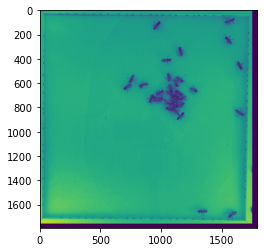

In [44]:
p = '/home/dieumynguyen/BeeSegmentation/data/processed/images/bw_sec_1005.npy'
p = np.load(p)
plt.imshow(p)

In [97]:
p.shape

(1792, 1792)

In [98]:
1792/2

896.0

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
%config IPCompleter.greedy=True

In [47]:
import os 
import cv2
import sys
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# Pytorch 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler


# Other custom files
sys.path.append('../')
import modules.dataset as data_handler
import modules.transforms as transforms
import modules.model as model

# Global variables

In [48]:
CROP_DIM = 256
BATCH_SIZE = 1
NUM_CLASSES = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 1000
SAVE_FREQ = 100
TEST_SPLIT = 0.2
VAL_SPLIT = 0.1

CLASS_WEIGHTS = True

SEED = 42

In [49]:
min_blob_size = 5 #20
max_blob_size = 40 #200
dist_min = 15 # default: 20

In [50]:
# Check for gpu
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f'Running on device: {device}\n')

Running on device: cuda:1



# Dataset

In [51]:
data_root = '/home/dieumynguyen/BeeSegmentation/data/processed'

## Transforms

In [52]:
test_data_transforms = torchvision.transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalizer()
])

## Load data

In [53]:
dataset = data_handler.BeeDataset(data_root)

Loading paths...
Num paths loaded: 125


# Test set

In [54]:
TEST_SET = False

In [55]:
if TEST_SET:
    df_path = os.path.join(data_root, f'train_val_test_idxs_transpose.pt')
    split_dict = torch.load(df_path)
    test_idxs = split_dict['test_idxs']
else:
    test_idxs = np.arange(0, len(dataset))

In [56]:
filenames = glob.glob(os.path.join(data_root, 'images/*', ))

In [57]:
filenames = [f.split('/')[-1].split('.')[0] for f in filenames]

In [58]:
np.save(os.path.join(data_root, 'img_file_names'), filenames)

# Data sampler

In [59]:
sampler_test = SequentialSampler(test_idxs)

# Data loaders

In [60]:
class SubImageCropper():
    def __init__(self, crop_dim=256, random_cropping=True, transforms=None):
        self.crop_dim = crop_dim
        self.random_cropping = random_cropping
        self.transforms = transforms
                 
    def count_divs(self, m, n):
        X = np.arange(0, m, self.crop_dim)
        Y = np.arange(0, n, self.crop_dim)
        num_divs = X.shape[0] * Y.shape[0]
        return num_divs, X, Y
        
    def __call__(self, batch):
        cropped_images = []
        cropped_masks = []
                
        # For each image in batch, crop into x subimages by random or sequential cropping
        for i, (image, mask, path) in enumerate(batch):
            img_shape = image.shape
                        
            # Find number of divs: number of squares that fit into the rectangular img
            h, w = img_shape[:]
            divs, Y, X = self.count_divs(h, w)
            
            # Random cropping
            if self.random_cropping:
                # Get -divs- number of croppings
                for div_i in range(divs):
                    x1 = np.random.randint(0, img_shape[1]-self.crop_dim)
                    y1 = np.random.randint(0, img_shape[0]-self.crop_dim)

                    x2 = x1 + self.crop_dim
                    y2 = y1 + self.crop_dim

                    cropped_image = image[y1:y2, x1:x2]
                    cropped_mask = mask[y1:y2, x1:x2]
                    
                    if self.transforms:
                        cropped_image, cropped_mask = self.transforms((cropped_image, cropped_mask))
                        
                    cropped_images.append(cropped_image)
                    cropped_masks.append(cropped_mask)

            # Sequential cropping
            else:
                for y1 in Y:
                    for x1 in X:
                        x2 = x1 + self.crop_dim
                        y2 = y1 + self.crop_dim
                        
                        cropped_image = image[y1:y2, x1:x2]
                        cropped_mask = mask[y1:y2, x1:x2]
                    
                        if self.transforms:
                            cropped_image, cropped_mask = self.transforms((cropped_image, cropped_mask))

                        cropped_images.append(cropped_image)
                        cropped_masks.append(cropped_mask)
            
        # Return the list of cropped images and masks
        return torch.stack(cropped_images), torch.stack(cropped_masks), path

In [61]:
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler_test, 
                         collate_fn=SubImageCropper(crop_dim=256, random_cropping=False, transforms=test_data_transforms))


In [62]:
for x, y, path in test_loader:
    break

In [63]:
x.shape, y.shape

(torch.Size([49, 1, 128, 128]), torch.Size([49, 1, 128, 128]))

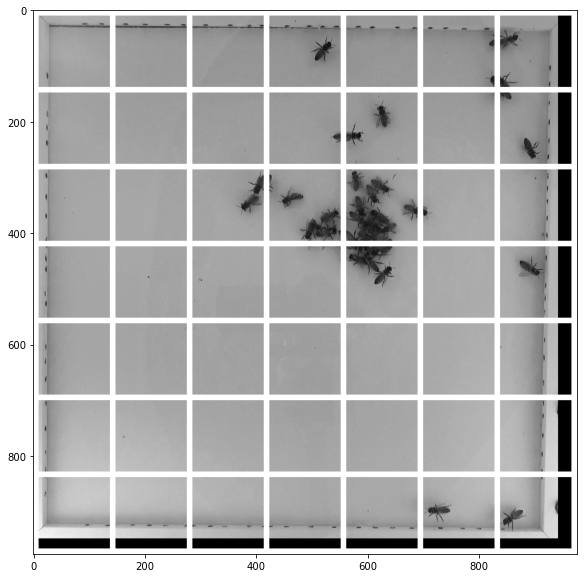

In [64]:
# Show random crops in batch
plt.figure(figsize=(14,10))
img = make_grid(x, nrow=7, normalize=True, pad_value=1, padding=10).permute(1,2,0)
plt.imshow(img);

In [65]:
test = y[17].cpu().permute(1,2,0).detach().numpy()

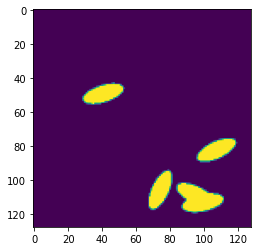

In [66]:
plt.imshow(test)

In [67]:
num_regions, regions, stats, centroids = cv2.connectedComponentsWithStats(test.astype(np.uint8))


In [68]:
stats

array([[    0,     0,   128,   128, 15577],
       [   30,    44,    23,    12,   175],
       [   97,    76,    22,    13,   174],
       [   68,    95,    13,    22,   177],
       [   85,   102,    27,    17,   281]], dtype=int32)

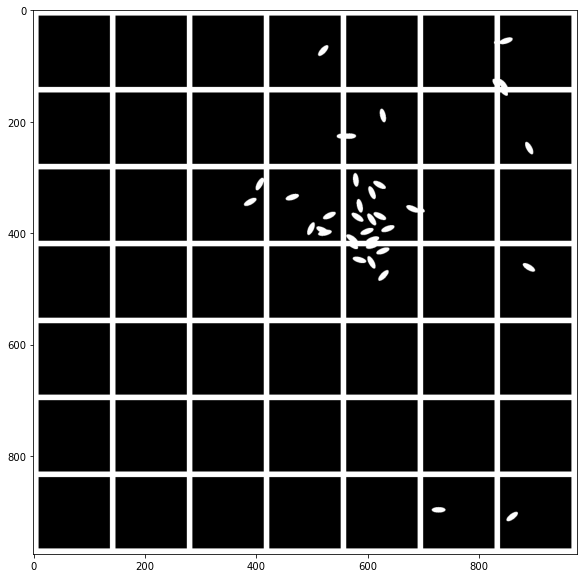

In [69]:
plt.figure(figsize=(14,10))
mask = make_grid(y.float(), nrow=7, normalize=True, pad_value=1, padding=10).permute(1,2,0)
plt.imshow(mask);

# Load class weights

In [70]:
class_weights = np.load(os.path.join(data_root, 'class_weights.npy'))
class_weights = torch.tensor(class_weights).float()

# Model

In [71]:
net = model.UNet(NUM_CLASSES, upsampling='transpose').to(device)

# Optimizer and criterion

In [72]:
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [73]:
np.random.seed(SEED)
torch.manual_seed(SEED)

if CLASS_WEIGHTS:
    print('Sending class weights')
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
else:
    criterion = nn.CrossEntropyLoss()

Sending class weights


# Evaluation

In [74]:
def compute_iou(ground_truth, prediction):
    ious = []
    for i, (gt, pr) in enumerate(zip(ground_truth, prediction)):
        gt = gt.squeeze().cpu()
        pr = pr.squeeze().cpu()

        intersection = gt & pr
        union = gt | pr
        iou = (intersection.sum() / union.sum()).item()
        ious.append(iou)
    mIOU = np.mean(ious)
    return mIOU

In [75]:
def _find_main_axis(regions, region_index):
    xs, ys = np.where(regions == region_index)
    m = np.concatenate([-ys[:, np.newaxis], xs[:, np.newaxis]], axis=1)
    _, _, v = np.linalg.svd(m - np.mean(m, axis=0), full_matrices=False)
    return np.arctan2(v[0, 0], v[0, 1])

In [76]:
def find_positions(array, min_blob_size, max_blob_size):
    num_regions, regions, stats, centroids = cv2.connectedComponentsWithStats(array.astype(np.uint8))
    
    result = []
    stats_info = []
    for region_index in np.arange(1, num_regions):
        region_stats = stats[region_index]

        # Remove too big or too small blobs
        region_width, region_height = region_stats[2], region_stats[3]
        if region_width < min_blob_size or region_width > max_blob_size \
                or region_height < min_blob_size or region_height > max_blob_size:
            continue

        # Get blob properties : main axis and centroid
        ax = _find_main_axis(regions, region_index)
        x, y = centroids[region_index][0], centroids[region_index][1]

        # Find object type (biggest occurence in the region)
        unique_values, count = np.unique(array[regions == region_index], return_counts=True)
        typ = unique_values[np.argmax(count)]

        result.append([x, y, typ, ax])
        
        bee_stats = {"x": int(region_stats[0]), "y": int(region_stats[1]), 
                     "h": int(region_stats[2]), "w": int(region_stats[3]), "id": "individual"}
        stats_info.append(bee_stats)

    result = np.array(result)
    return result, stats_info

In [77]:
# Compute error metrics
def calculate_points_dist(preds, labels):
    # euclidean distance between pred and label
    res = np.zeros((len(preds), len(labels)))

    for ip in range(len(preds)):
        for il in range(len(labels)):
            pred = preds[ip]
            label = labels[il]
            res[ip, il] = np.sqrt((pred[0] - label[0]) ** 2 + (pred[1] - label[1]) ** 2)

    return res

In [78]:
def compute_error_metrics(result_label, result_pred, dist_min=20):
    # Find matches in dist_matrix, until no more values close to match
    TP_results = []
    correct_type = 0
    pixel_dist = []
    
    dist_matrix = calculate_points_dist(result_pred, result_label)

    while dist_matrix.shape[0] > 0 and dist_matrix.shape[1] > 0 and np.min(dist_matrix) < dist_min:
        # Find where min is iteratively, get idx for pred and for label arrays
        ip, il = np.argwhere(dist_matrix == np.min(dist_matrix))[0]

        # Assign values of pred and label arrays
        xp, yp, tp, ap = tuple(result_pred[ip])
        xl, yl, tl, al = tuple(result_label[il])

        # Count this pred as true positive
        TP_results.append(result_pred[ip])

        # Amount of pixels bw the pred and label
        pixel_dist.append(dist_matrix[ip, il])

        # Check if correct label 
        correct_type += int(tp == tl)

        # Remove the min already check, now check the next up min until hits dist_min threshold
        dist_matrix = np.delete(dist_matrix, ip, 0)
        dist_matrix = np.delete(dist_matrix, il, 1)
        result_pred = np.delete(result_pred, ip, axis=0)
        result_label = np.delete(result_label, il, axis=0)

    # The rest bestcomes false negatives and false positives
    FN_results = result_label
    FP_results = result_pred
    
    return pixel_dist, correct_type, TP_results, FN_results, FP_results

In [79]:
def tp_fp_evaluate(pred, label, min_blob_size, max_blob_size, dist_min):
    result_pred, _ = find_positions(pred, min_blob_size, max_blob_size)
    result_label, _ = find_positions(label, min_blob_size, max_blob_size)
    
    pixel_dist, correct_type, TP_results, FN_results, FP_results = compute_error_metrics(result_label, result_pred, dist_min=20)
    
    TP_count, FP_count, FN_count, correct_type_count = 0, 0, 0, 0
    all_pixel_dist, all_axis_diff = [], []

    TP_count += len(TP_results)
    FN_count += len(FN_results)
    FP_count += len(FP_results)
    correct_type_count += correct_type
    all_pixel_dist += pixel_dist
    
    try:
        TP_rate = TP_count / (TP_count + FN_count)
    except ZeroDivisionError:
        TP_rate = 'NA'
        
    return TP_rate, TP_results

# Test

### Load a model

In [80]:
epoch_i = 902
model_path = os.path.join(data_root, 'model_transpose', f'segmentation_epoch{epoch_i:05}.pt')

In [81]:
load_dict = torch.load(model_path)
net.load_state_dict(load_dict['model'])
optimizer.load_state_dict(load_dict['optim'])

### Visualize performance

In [82]:
def make_color_pred(pred_img):
    colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0)]
    color_pred = np.zeros_like(pred_img)
    for ch in range(pred_img.shape[2]):
        tmp = pred_img[:,:,0]
        color_pred[np.where(tmp==ch)] = colors[ch]
    color_pred.shape
    return color_pred

In [91]:
net.eval()

data_log = {}

overlay_imgs = []
correct_ims = []
mIOUs = []
accs = []
tprs = []
for batch_i, (x, y, path) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    
    path = path.split('/')[-1].split('.')[0]
    
    with torch.no_grad():
        y_pred_full = net(x)
        y_pred = y_pred_full.argmax(dim=1)
        
        acc = (y_pred == y).float().mean()
        accs.append(acc.cpu().detach().item())
        
        y_pred = y_pred.cpu().detach().unsqueeze(dim=1)
        
        pred_img = make_grid(y_pred.float(), nrow=7, normalize=False).permute(1,2,0).detach().numpy()
        truth_img = make_grid(y.float(), nrow=7, normalize=False).permute(1,2,0).cpu().detach().numpy()
        orig = make_grid(x.float(), nrow=7, normalize=True).permute(1,2,0).cpu().detach().numpy()
        
        orig2 = orig[:,:,0]
        cv2.imwrite(os.path.join(data_root, 'imgs_resized.png'), orig2)
        
        #### Make data log 
        pred_img_2 = pred_img[:,:,0]
        truth_img_2 = truth_img[:,:,0]
        pred_results, pred_bee_stats  = find_positions(pred_img_2, min_blob_size, max_blob_size)
        truth_results, truth_bee_stats = find_positions(truth_img_2, min_blob_size, max_blob_size)
        ####
        
        color_pred = make_color_pred(pred_img)
        
        overlay_img = orig.copy()
        for val in range(1, 3):
            overlay_img[pred_img==val] = color_pred[pred_img==val]
        overlay_imgs.append(overlay_img)
        
        correct_im = (pred_img == truth_img).astype(np.float)
        correct_ims.append(correct_im)
        
        # For batch:
        batch_tps = []
        for img_i, (label, pred) in enumerate(zip(y, y_pred)):
            label = label.cpu().float().permute(1,2,0).detach().numpy()
            pred = pred.float().permute(1,2,0).detach().numpy()
            TP_rate, TP_results = tp_fp_evaluate(pred, label, min_blob_size=min_blob_size, 
                             max_blob_size=max_blob_size, dist_min=dist_min)
            batch_tps.append(TP_rate)
        batch_tps = [tp for tp in batch_tps if tp != 'NA'] # Remove 'NAs'
        batch_avg_tp = np.mean(batch_tps)
        tprs.append(batch_avg_tp)
        
    sys.stdout.write(f'\rBatch {batch_i+1}/{len(test_loader)} '
                     f'-- Acc: {acc:0.4f}  -- TPR: {batch_avg_tp}')
    sys.stdout.flush()
    
    
    data_log[path] = truth_bee_stats
    
    break
    
#     if batch_i > 14:
#         break

Batch 1/125 -- Acc: 0.9806  -- TPR: 0.9555555555555556

In [94]:
orig2.shape

(912, 912)

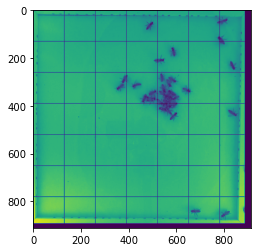

In [92]:
plt.imshow(orig2)

In [86]:
orig.shape

(912, 912, 3)

In [100]:
with open(os.path.join(data_root, 'data_log.json'), 'w') as f:
    json.dump(data_log, f)

In [40]:
# Avg accuracy and mIOU
np.mean(accs), np.mean(mIOUs), np.mean(tprs)

/home/dieumynguyen/anaconda3/envs/dm_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dieumynguyen/anaconda3/envs/dm_env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.9805828332901001, nan, 0.9555555555555556)

In [41]:
# Choose a random batch to show overlay imgs
rand_i = np.random.randint(len(overlay_imgs))
rand_i

0

In [42]:
tprs[rand_i]

0.9555555555555556

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


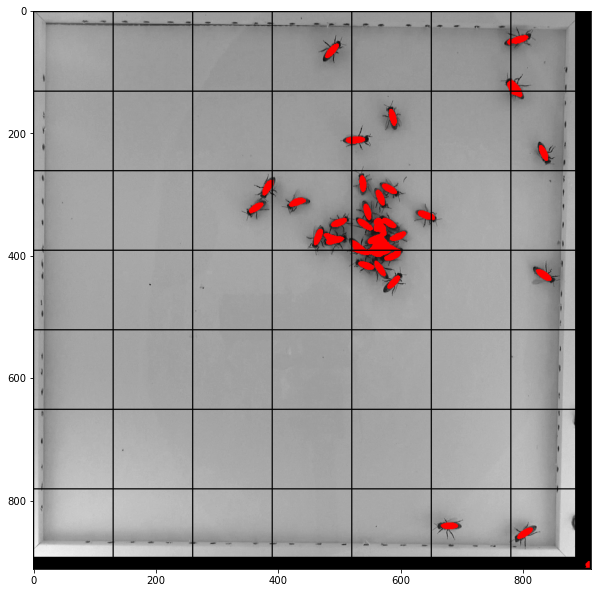

In [43]:
plt.figure(figsize=(10, 14))
plt.imshow(overlay_imgs[rand_i]);

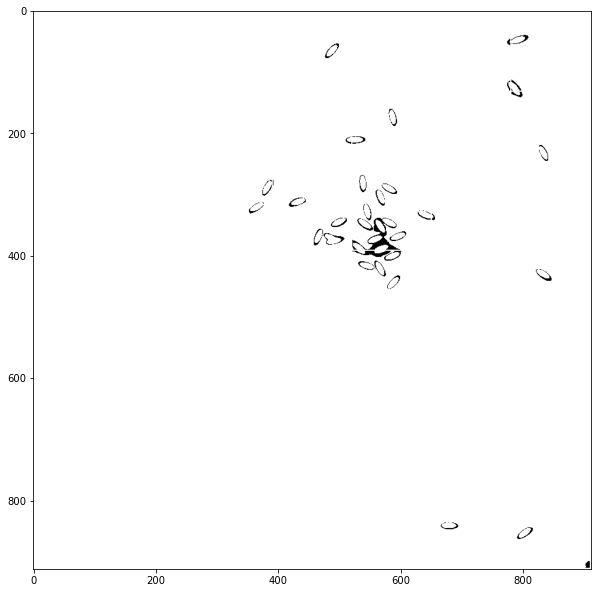

In [44]:
plt.figure(figsize=(10, 14))
plt.imshow(correct_ims[rand_i])

# Full image

In [45]:
min_blob_size = 5 #20
max_blob_size = 40 #200
dist_min = 15 # default: 20

In [46]:
pred_img = make_grid(y_pred.float(), nrow=7, normalize=False, padding=0).permute(1,2,0).detach().numpy()
truth_img = make_grid(y.float(), nrow=7, normalize=False, padding=0).permute(1,2,0).cpu().detach().numpy()
orig = make_grid(x.float(), nrow=7, normalize=True, padding=0).permute(1,2,0).cpu().detach().numpy()

In [47]:
pred_img = pred_img[:,:,0]
truth_img = truth_img[:,:,0]
orig = orig[:,:,0]

In [64]:
pred_results, pred_bee_stats = find_positions(pred_img, min_blob_size, max_blob_size)

In [65]:
truth_results, truth_bee_stats = find_positions(truth_img, min_blob_size, max_blob_size)

In [66]:
_, _, TP_results, _, _ = compute_error_metrics(truth_results, pred_results, dist_min)

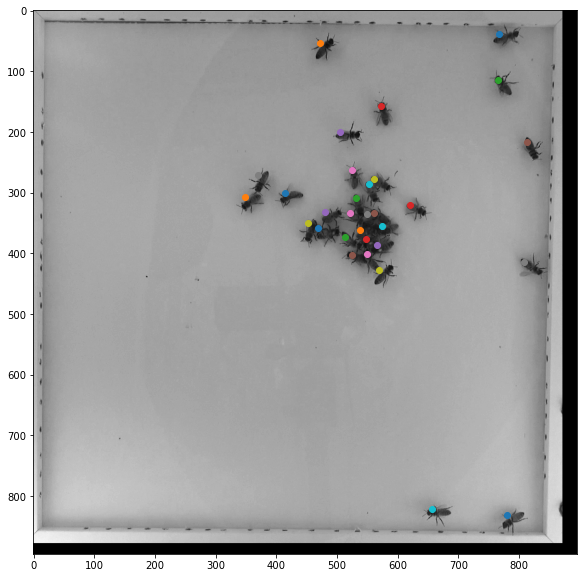

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(orig, 'gray')
for stat in truth_bee_stats:
    plt.scatter(stat['x'], stat['y'])

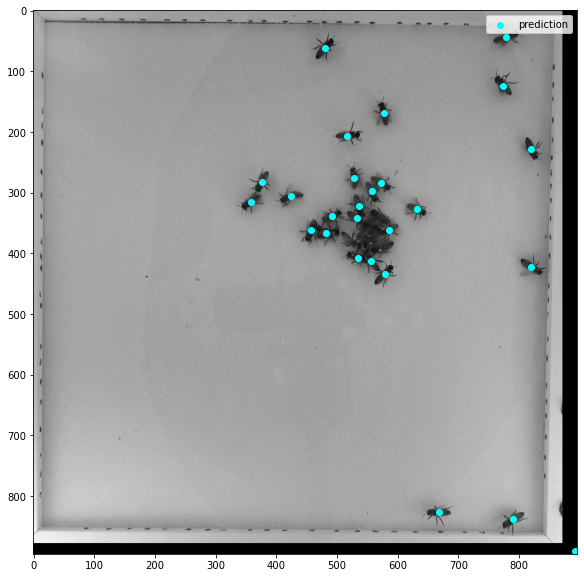

In [67]:
plt.figure(figsize=(10,10))
plt.scatter(pred_results[:,0], pred_results[:,1], label='prediction', c='cyan')
# plt.scatter(truth_results[:,0], truth_results[:,1], label='truth')
# plt.scatter(TP_results[:,0], TP_results[:,1], label='TP')
plt.legend()
plt.imshow(orig, 'gray')

In [59]:
kernel = np.ones((2,2), np.uint8)
erosion = cv2.erode(pred_img, kernel, iterations=3)

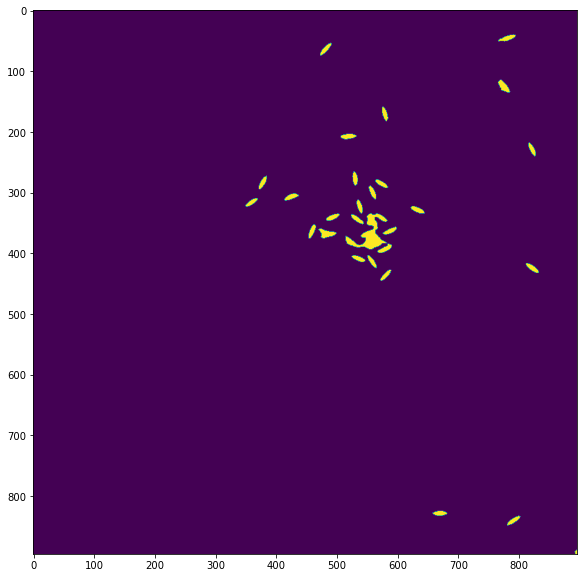

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(erosion)

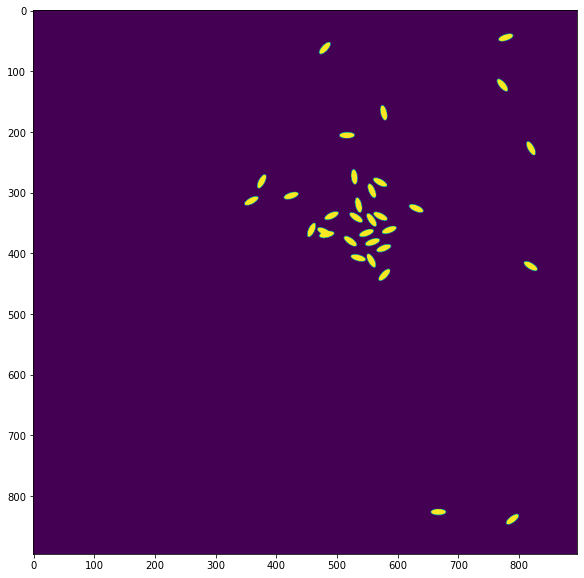

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(truth_img)

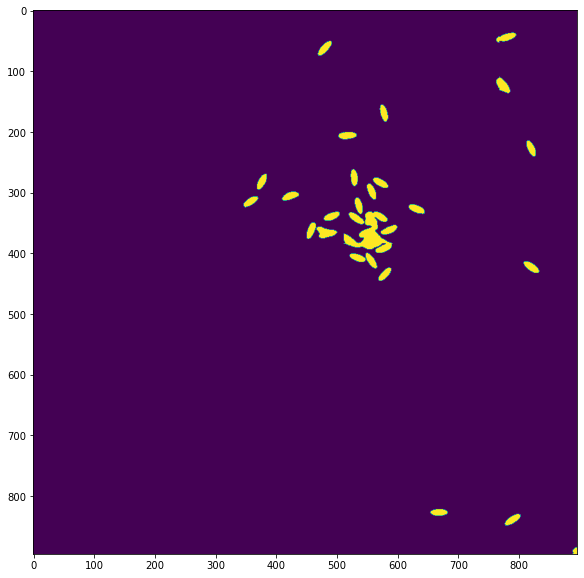

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(pred_img)